In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

varying_sample_sizes = [50, 100, 150, 200, 250]#, 300, 350, 400]
fixed_n_complementary = 100
n_host = 100 
 # set to None if both candidates have the same sample size


n_rct_before_split = 10**5
std_true_y = 1
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

np.random.seed(42)

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 5 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    - 4 * X["X_2"] * T  # causal
    + eps
)
if include_intercept:
    true_params = np.array([1, 1, -1, 1, 4, 2, 2, 0])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 4, 2, 2, 0])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0, 0])
else:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}


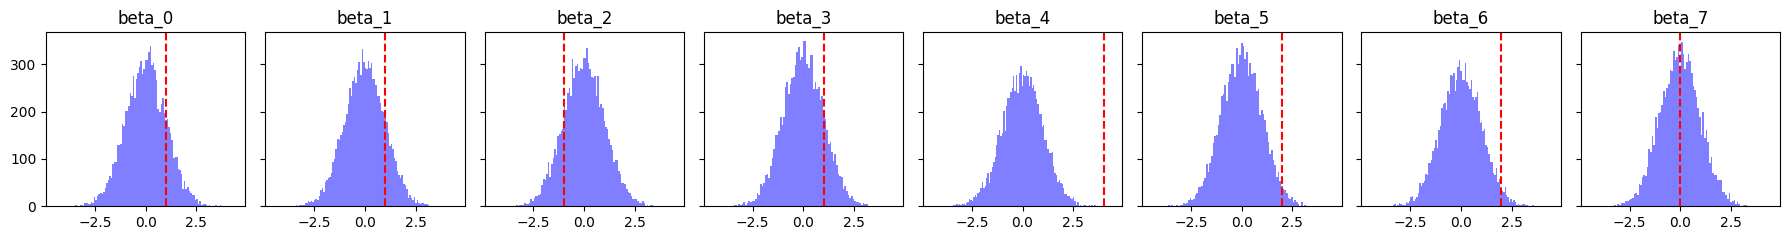

In [4]:
# only meaningful if the outcome model is linear 

# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [5]:


n_seeds = 10
data_parameters = {
    "fixed_n_complementary": fixed_n_complementary,
    "varying_sample_sizes": varying_sample_sizes,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [6]:
# exact_data = generate_exact_data_varying_sample_size(
#     data_parameters, include_intercept=bool(include_intercept)
# )
# dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
#     linear_eig_closed_form_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#     )
# )

In [7]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []
store_non_exact_data = {}

for i in range(n_seeds):
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), seed=i)
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )
    store_non_exact_data[i] = nonexact_data


EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)


        X_0       X_1       X_2  T
0  0.846031  3.619991  0.005186  1
1  0.825415  4.246403  0.035583  0
2  0.812954  2.420428  0.050076  1
3  0.734993  4.603845  0.434165  0
4  0.953977  3.263476  0.037493  1
        X_0       X_1       X_2  T
0  0.846031  3.619991  0.005186  1
1  0.825415  4.246403  0.035583  1
2  0.812954  2.420428  0.050076  1
3  0.734993  4.603845  0.434165  1
4  0.953977  3.263476  0.037493  1
        X_0       X_1       X_2  T
0  0.846031  3.619991  0.005186  1
1  0.825415  4.246403  0.035583  0
2  0.812954  2.420428  0.050076  1
3  0.734993  4.603845  0.434165  1
4  0.953977  3.263476  0.037493  1
        X_0       X_1       X_2  T
0  0.846031  3.619991  0.005186  0
1  0.825415  4.246403  0.035583  1
2  0.812954  2.420428  0.050076  1
3  0.734993  4.603845  0.434165  0
4  0.953977  3.263476  0.037493  1
        X_0       X_1       X_2  T
0  0.846031  3.619991  0.005186  1
1  0.825415  4.246403  0.035583  0
2  0.812954  2.420428  0.050076  1
3  0.734993  4.60384

KeyboardInterrupt: 

In [ ]:
def turn_into_diff(arr):
    n, d = np.shape(arr)[0], np.shape(arr)[1]
    result = np.zeros((n//2, d))
    for i in range (n//2):
        result[i,:]=arr[2*i,:]-arr[(2*i) +1,:]
    return result

In [ ]:
merged_datasets = {i:{} for i in range (len(store_non_exact_data.keys()))}

for seed, seed_data_dict in store_non_exact_data.items():
    for sample_size, data_dict in seed_data_dict.items():
        merged_data_dict={}
        for name, data in data_dict.items():
            if name != 'host':
                merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
        merged_datasets[seed][sample_size] = merged_data_dict

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():
            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression()
            model.fit(X,Y,)
            Y_pred = model.predict(X)
            mse = mean_squared_error(Y, Y_pred)
            merged_mse[sample_size][cand_name].append(mse)

mean_mse = []
for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array = mse_array[:,0] - mse_array[:,1] #twin - complementary : should be >0 if twin is best to begin with
    mean_mse.append(np.mean(mse_array))

print(mean_mse)

[0.034270615371960945, 0.01592348189501085, -0.02513791123233683, 0.003688299606430423, -0.008262079190823512]


<Figure size 1500x1000 with 0 Axes>

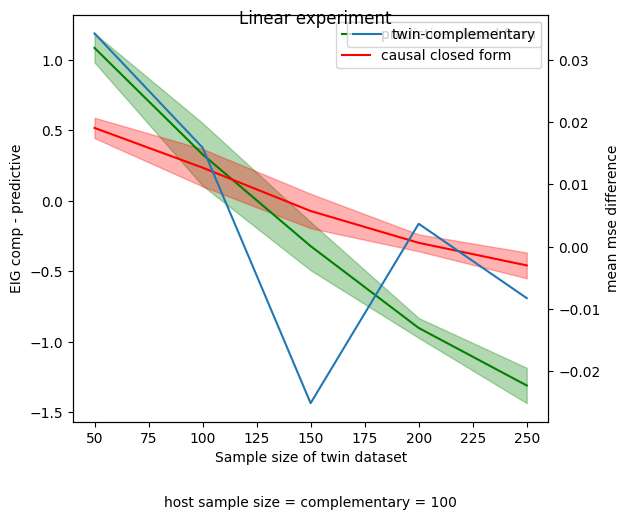

In [ ]:
dict_diff_EIG_closed_form_across_seeds = {'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds),\
                                         'causal closed form':turn_into_diff(EIG_caus_closed_form_across_seeds)}
dict_mean_mse={'twin-complementary': mean_mse}


color_dict = {'predictive closed form': 'green', 'causal closed form': 'red'}

plot_dict(
    x = varying_sample_sizes,
    dict = dict_diff_EIG_closed_form_across_seeds,
    axis_names=["Sample size of twin dataset", "EIG comp - predictive", "mean mse difference"],
    dict_additional_plots=None,
    text="host sample size = complementary = 100",
    title= "Linear experiment",
    color_dict=color_dict,
    second_axis=dict_mean_mse
)


### 2. EIG from samples for varying sample sizes

In [ ]:
n_samples_outer_expectation_obs = 200
n_samples_inner_expectation_obs = 400
n_samples_outer_expectation_caus = 400
n_samples_inner_expectation_caus = 800

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [ ]:
# dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
#     linear_eig_from_samples_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#         sampling_parameters
#     )
# )

# EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []


# EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
# EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)

In [ ]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range(5):
    EIGs = linear_eig_from_samples_varying_sample_size(
        store_non_exact_data[i], data_parameters, prior_hyperparameters, sampling_parameters
    )
    EIG_obs_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )


KeyboardInterrupt: 

In [ ]:
store_non_exact_data0[0][50]['host'].equals(store_non_exact_data[0][50]['host'])

False

In [ ]:
EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)

diff_EIG_obs_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_obs_samples_across_seeds)}
diff_EIG_caus_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_caus_samples_across_seeds)}

plot_dict(
    x = varying_sample_sizes,
    dict = diff_EIG_obs_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
    dict_additional_plots=None,
    text=None,
    title= "EIG obs from samples"
)

plot_dict(
    x = varying_sample_sizes,
    dict = diff_EIG_caus_samples_across_seeds,
    axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
    dict_additional_plots=None,
    text=None,
    title= "EIG caus from samples"
)


In [ ]:
dict_all_diff = {'predictive mcmc': turn_into_diff(EIG_obs_samples_across_seeds), 'causal mcmc': turn_into_diff(EIG_caus_samples_across_seeds), \
                 'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds), 'causal closed form': turn_into_diff(EIG_caus_closed_form_across_seeds)}
color_dict = {'predictive mcmc': 'blue', 'causal mcmc': 'orange', \
                 'predictive closed form': 'green', 'causal closed form': 'red'}
plot_dict(
    x = varying_sample_sizes,
    dict = dict_all_diff,
    color_dict = color_dict,
    axis_names=["Sample size of candidate datasets", "EIG obs closed form", "merged CATE"],
    dict_additional_plots=None,
    text=None,
    title= "Expected Information Gain",
)

### Ground truth : merging and fitting CATE

In [ ]:
merged_datasets = {i:{} for i in range (len(store_non_exact_data.keys()))}

for seed, seed_data_dict in store_non_exact_data.items():
    for sample_size, data_dict in seed_data_dict.items():
        merged_data_dict={}
        for name, data in data_dict.items():
            if name != 'host':
                merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
        merged_datasets[seed][sample_size] = merged_data_dict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():
            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression()
            model.fit(X,Y)
            Y_pred = model.predict(X)
            mse = mean_squared_error(Y, Y_pred)
            merged_mse[sample_size][cand_name].append(mse)

print(merged_mse[50])

mean_mse = []
for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array = mse_array[:,1] - mse_array[:,0] #twin - complementary : should be >0 if twin is best to begin with
    mean_mse.append(np.mean(mse_array))

print(mean_mse)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():
            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression()
            model.fit(X,Y)
            Y_pred = model.predict(X)
            mse = mean_squared_error(Y, Y_pred)
            merged_mse[sample_size][cand_name].append(mse)

mean_mse = []
for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array = mse_array[:,1] - mse_array[:,0] #twin - complementary : should be >0 if twin is best to begin with
    mean_mse.append(np.mean(mse_array))
